<a href="https://colab.research.google.com/github/danil99152/prediction-of-government-tenders/blob/main/auction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
* Добавить реальный наглядный тест (10-20 примеров)

#Import

In [1]:
!pip install catboost

     |████████████████████████████████| 69.2MB 43kB/s 


In [2]:
from datetime import datetime, date
import math
import re
import gc

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sbs
from statsmodels.graphics.mosaicplot import mosaic


from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
import catboost as ctb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMClassifier

import joblib
import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!gdown --id 1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU

Downloading...
From: https://drive.google.com/uc?id=1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU
To: /content/purchase_plans.csv
5.74MB [00:00, 50.8MB/s]


#Обработка данных

Считывание данных о заявках

In [156]:
contract_path = 'purchase_plans.csv'
dtypes = {'plan_number' : 'category', 
          'customer_legal_form' : 'category', 
          'KTRU' : 'category',
          'publicDiscussion' : 'category',
          'isEnergyServiceContract': 'category',
          'KVRInfo': 'category',
          'OKFS': 'category'}
data = pd.read_csv(contract_path, dtype = dtypes)
gc.collect()
data.head()

,plan_number,customer_legal_form,OKFS,KVRInfo,positionCanceled,publicDiscussion,total,time,OKPD,log_total,maxPrice,log_maxPrice
0,201703133000188001,75403,14.0,244.0,False,False,524637.0,731,35.14.10.000,13.170462,174879.0,12.071850
1,201703133000164001,75404,14.0,244.0,False,False,30000.0,182,35.11.10.110,10.308953,11700.0,9.367344
2,201703131000014001,75103,12.0,244.0,False,False,7800000.0,1461,35.30.11.120,15.869634,2600000.0,14.771022
3,201703131000014001,75103,12.0,244.0,False,False,3675000.0,731,35.11.10.110,15.117064,1225000.0,14.018451
4,201703131000014001,75103,12.0,244.0,False,False,900000.0,731,35.30.12.120,13.710150,300000.0,12.611538


In [157]:
data = data.drop(['plan_number','log_total', 'log_maxPrice'], axis=1)

In [158]:
def OKPD_mapping(row):
  try:
    x, y = row.split(".", 1)
  except ValueError:
    x = row
  return x

data['OKPD'] = data['OKPD'].map(OKPD_mapping)

#Анализ

Прохождение и тип продукта

In [131]:
OKPD = {
    '01' : 'Продукция и услуги сельского хозяйства и охоты',
    '02' : 'Продукция лесоводства, лесозаготовок и связанные с этим услуги',
    '03' : 'Рыба и прочая продукция рыболовства и рыбоводства; услуги, связанные с рыболовством и рыбоводством',
    '05' : 'Уголь',
    '06' : 'Нефть и газ природный',
    '07' : 'Руды металлические',
    '08' : 'Продукция горнодобывающих производств прочая',
    '09' : 'Услуги в области добычи полезных ископаемых',
    '10' : 'Продукты пищевые',
    '11' : 'Напитки',
    '12' : 'Изделия табачные',
    '13' : 'Текстиль и изделия текстильные',
    '14' : 'Одежда',
    '15' : 'Кожа и изделия из кожи',
    '16' : 'Древесина и изделия из дерева и пробки, кроме мебели; изделия из соломки и материалов для плетения',
    '17' : 'Бумага и изделия из бумаги',
    '18' : 'Услуги печатные и услуги по копированию звуко- и видеозаписей, а также программных средств',
    '19' : 'Кокс и нефтепродукты',
    '20' : 'Вещества химические и продукты химические',
    '21' : 'Средства лекарственные и материалы, применяемые в медицинских целях',
    '22' : 'Изделия резиновые и пластмассовые',
    '23' : 'Продукты минеральные неметаллические прочие',
    '24' : 'Металлы основные',
    '25' : 'Изделия металлические готовые, кроме машин и оборудования',
    '26' : 'Оборудование компьютерное, электронное и оптическое',
    '27' : 'Оборудование электрическое',
    '28' : 'Машины и оборудование, не включенные в другие группировки',
    '29' : 'Средства автотранспортные, прицепы и полуприцепы',
    '30' : 'Средства транспортные и оборудование, прочие',
    '31' : 'Мебель',
    '32' : 'Изделия готовые прочие',
    '33' : 'Услуги по ремонту и монтажу машин и оборудования',
    '35' : 'Электроэнергия, газ, пар и кондиционирование воздуха',
    '36' : 'Вода природная; услуги по очистке воды и водоснабжению',
    '37' : 'Услуги по водоотведению; шлам сточных вод',
    '38' : 'Услуги по сбору, обработке и удалению отходов; услуги по утилизации отходов',
    '39' : 'Услуги по рекультивации и прочие услуги по утилизации отходов',
    '41' : 'Здания и работы по возведению зданий',
    '42' : 'Сооружения и строительные работы в области гражданского строительства',
    '43' : 'Работы строительные специализированные',
    '45' : 'Услуги по оптовой и розничной торговле и услуги по ремонту автотранспортных средств и мотоциклов',
    '46' : 'Услуги по оптовой торговле, кроме оптовой торговли автотранспортными средствами и мотоциклами',
    '47' : 'Услуги по розничной торговле, кроме розничной торговли автотранспортными средствами и мотоциклами',
    '49' : 'Услуги сухопутного и трубопроводного транспорта',
    '50' : 'Услуги водного транспорта',
    '51' : 'Услуги воздушного и космического транспорта',
    '52' : 'Услуги по складированию и вспомогательные транспортные услуги',
    '53' : 'Услуги почтовой связи и услуги курьерские',
    '55' : 'Услуги по предоставлению мест для временного проживания',
    '56' : 'Услуги общественного питания',
    '58' : 'Услуги издательские',
    '59' : 'Услуги по производству кинофильмов, видеофильмов и телевизионных программ, звукозаписей и изданию музыкальных записей',
    '60' : 'Услуги в области теле- и радиовещания',
    '61' : 'Услуги телекоммуникационные',
    '62' : 'Продукты программные и услуги по разработке программного обеспечения; консультационные и аналогичные услуги в области информационных технологий',
    '63' : 'Услуги в области информационных технологий',
    '64' : 'Услуги финансовые, кроме услуг по страхованию и пенсионному обеспечению',
    '65' : 'Услуги по страхованию, перестрахованию и негосударственному пенсионному обеспечению, кроме обязательного социального обеспечения',
    '66' : 'Услуги вспомогательные, связанные с услугами финансового посредничества и страхования',
    '68' : 'Услуги по операциям с недвижимым имуществом',
    '69' : 'Услуги юридические и бухгалтерские',
    '70' : 'Услуги головных офисов; услуги консультативные в области управления предприятием',
    '71' : 'Услуги в области архитектуры и инженерно-технического проектирования, технических испытаний, исследований и анализа',
    '72' : 'Услуги и работы, связанные с научными исследованиями и экспериментальными разработками',
    '73' : 'Услуги рекламные и услуги по исследованию конъюнктуры рынка',
    '74' : 'Услуги профессиональные, научные и технические, прочие',
    '75' : 'Услуги ветеринарные',
    '77' : 'Услуги по аренде и лизингу',
    '78' : 'Услуги по трудоустройству и подбору персонала',
    '79' : 'Услуги туристических агентств, туроператоров и прочие услуги по бронированию и сопутствующие им услуги',
    '80' : 'Услуги по обеспечению безопасности и проведению расследований',
    '81' : 'Услуги по обслуживанию зданий и территорий',
    '82' : 'Услуги в области административного, хозяйственного и прочего вспомогательного обслуживания',
    '84' : 'Услуги в области государственного управления и обеспечения военной безопасности, услуги в области обязательного социального обеспечения',
    '85' : 'Услуги в области образования',
    '86' : 'Услуги в области здравоохранения',
    '87' : 'Услуги по предоставлению ухода с обеспечением проживания',
    '88' : 'Услуги социальные без обеспечения проживания',
    '90' : 'Услуги в области творчества, искусства и развлечений',
    '91' : 'Услуги библиотек, архивов, музеев и прочие услуги в области культуры',
    '92' : 'Услуги по организации и проведению азартных игр и заключению пари, лотерей',
    '93' : 'Услуги, связанные со спортом, и услуги по организации развлечений и отдыха',
    '94' : 'Услуги общественных организаций',
    '95' : 'Услуги по ремонту компьютеров, предметов личного потребления и бытовых товаров',
    '96' : 'Услуги персональные прочие',
    '97' : 'Услуги домашних хозяйств с наемными работниками',
    '98' : 'Продукция и различные услуги частных домашних хозяйств для собственных нужд',
    '99' : 'Услуги, предоставляемые экстерриториальными организациями и органами'
    }

In [191]:
def OKPD_mapping(row):
  try:
    x, y = row.split(".", 1)
    if x in OKPD:
      return OKPD[x]
    return 'Устаревшие категории'
  except ValueError:
    print('ValueError')

ValueError


29649

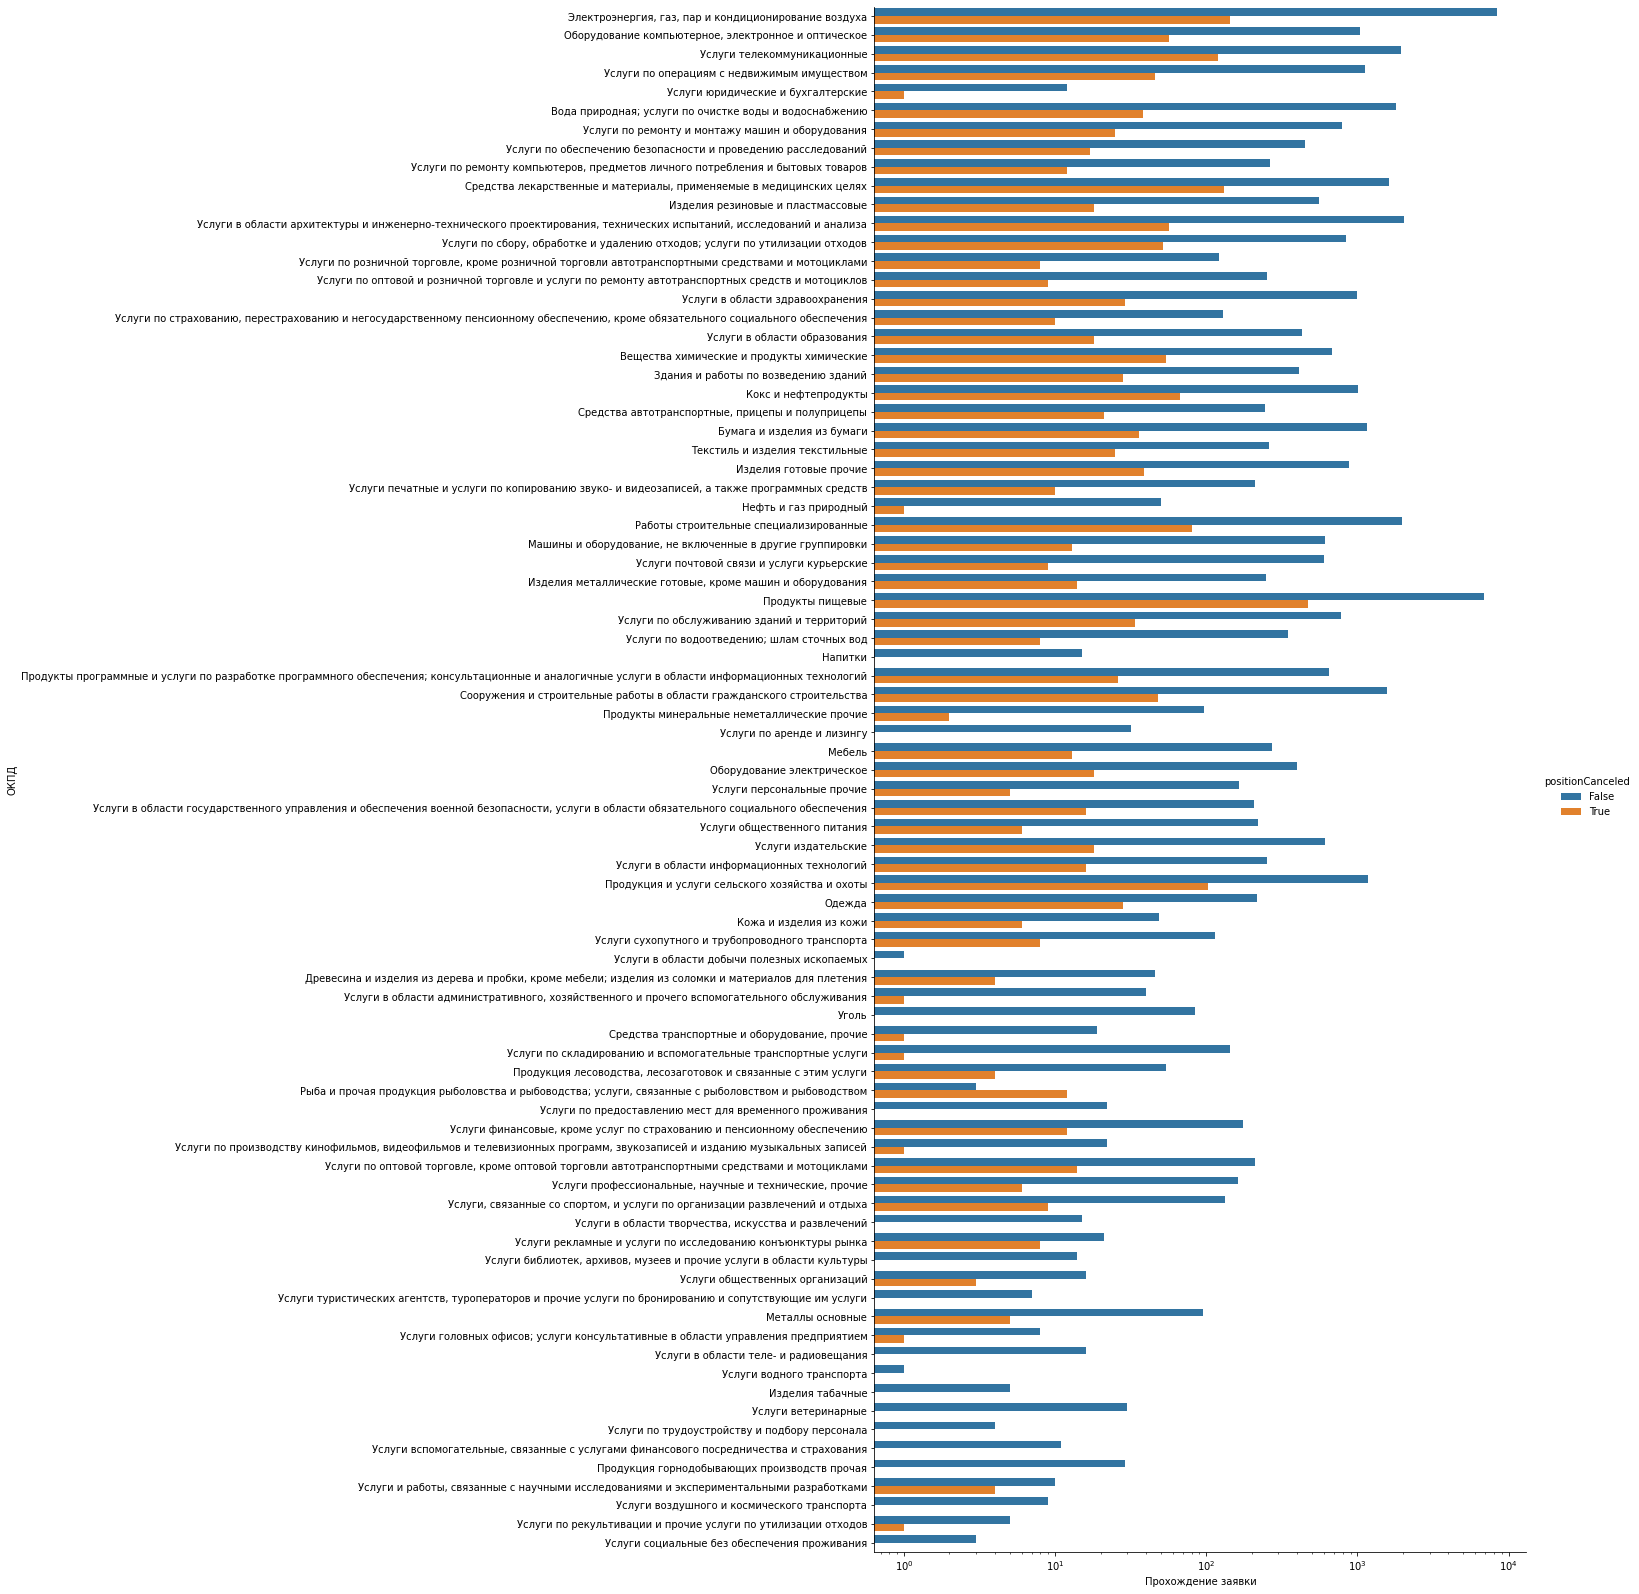

In [228]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['OKPD', 'positionCanceled'])
  data_to_plot['OKPD'] = data_to_plot['OKPD'].map(OKPD_mapping)
  g = sbs.catplot(y = 'OKPD', hue="positionCanceled", kind="count", height = 22, aspect = 1, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Прохождение заявки', ylabel = 'ОКПД')

del data_to_plot
del g
gc.collect()

In [ ]:
data.corr()

,total,time
total,1.000000,0.026131
time,0.026131,1.000000


Описание цены

In [ ]:
data['total'].describe()

count    4.920400e+04
mean     3.033807e+06
std      1.161167e+08
min      1.000000e-02
25%      2.800000e+04
50%      8.756000e+04
75%      2.999925e+05
max      7.154803e+09
Name: total, dtype: float64

In [ ]:
# Мода, медиана, среднее
result = {'mode': [], 'median': [], 'mean': []}
for nv in num_var:
    result['mode'].append(int(data[nv].mode()[0]))
    result['median'].append(int(data[nv].median()))
    result['mean'].append(int(data[nv].mean()))

result = pd.DataFrame(result, index=num_var)
result = result[['mode', 'median', 'mean']]
result

,mode,median,mean
total,50000,87560,3033806
time,365,258,255


In [31]:
OKOPF = {
    '10000' : 'Юридические лица - коммерческие корпоративные организации',
    '11000' : 'Хозяйственные товарищества',
    '11051' : 'Полные товарищества',
    '11064' : 'Товарищества на вере (коммандитные товарищества)',
    '12000' : 'Хозяйственные общества',
    '12200' : 'Акционерные общества',
    '12247' : 'Публичные акционерные общества',
    '12267' : 'Непубличные акционерные общества',
    '12300' : 'Общества с ограниченной ответственностью',
    '13000' : 'Хозяйственные партнерства',
    '14000' : 'Производственные кооперативы (артели)',
    '14100' : 'Сельскохозяйственные производственные кооперативы',
    '14153' : 'Сельскохозяйственные артели (колхозы)',
    '14154' : 'Рыболовецкие артели (колхозы)',
    '14155' : 'Кооперативные хозяйства (коопхозы)',
    '14200' : 'Производственные кооперативы',
    '15300' : 'Крестьянские (фермерские) хозяйства',
    '19000' : 'Юридические лица - прочие коммерческие организации',
    '20000' : 'Юридические лица - некоммерческие корпоративные организации',
    '20100' : 'Потребительские кооперативы',
    '20101' : 'Гаражные и гаражно-строительные кооперативы',
    '20102' : 'Жилищные или жилищно-строительные кооперативы',
    '20103' : 'Жилищные накопительные кооперативы',
    '20104' : 'Кредитные потребительские кооперативы',
    '20105' : 'Кредитные потребительские кооперативы граждан',
    '20106' : 'Кредитные кооперативы второго уровня',
    '20107' : 'Потребительские общества',
    '20108' : 'Общества взаимного страхования',
    '20109' : 'Сельскохозяйственные потребительские перерабатывающие кооперативы',
    '20110' : 'Сельскохозяйственные потребительские сбытовые (торговые) кооперативы',
    '20111' : 'Сельскохозяйственные потребительские обслуживающие кооперативы',
    '20112' : 'Сельскохозяйственные потребительские снабженческие кооперативы',
    '20113' : 'Объединения фермерских хозяйств',
    '20115' : 'Сельскохозяйственные потребительские животноводческие кооперативы',
    '20121' : 'Фонды проката',
    '20200' : 'Общественные организации',
    '20201' : 'Политические партии',
    '20202' : 'Профсоюзные организации',
    '20210' : 'Общественные движения',
    '20211' : 'Органы общественной самодеятельности',
    '20217' : 'Территориальные общественные самоуправления',
    '20600' : 'Ассоциации (союзы)',
    '20601' : 'Ассоциации (союзы) экономического взаимодействия субъектов Российской Федерации',
    '20603' : 'Советы муниципальных образований субъектов РФ',
    '20604' : 'Союзы (ассоциации) кредитных кооперативов',
    '20605' : 'Союзы (ассоциации) кооперативов',
    '20606' : 'Союзы (ассоциации) общественных объединений',
    '20608' : 'Союзы потребительских обществ',
    '20609' : 'Адвокатские палаты',
    '20610' : 'Нотариальные палаты',
    '20611' : 'Торгово-промышленные палаты',
    '20612' : 'Объединения работодателей',
    '20613' : 'Объединения фермерских хозяйств',
    '20614' : 'Некоммерческие партнерства',
    '20615' : 'Адвокатские бюро',
    '20616' : 'Коллегии адвокатов',
    '20619' : 'Саморегулируемые организации',
    '20620' : 'Объединения (ассоциации и союзы) благотворительных организаций',
    '20700' : 'Товарищества собственников недвижимости',
    '20702' : 'Садоводческие или огороднические некоммерческие товарищества',
    '20716' : 'Товарищества собственников жилья',
    '20900' : 'Учреждения',
    '21100' : 'Казачьи общества',
    '21200' : 'Общины коренных малочисленных народов РФ',
    '30000' : 'Организации без прав юридического лица',
    '30001' : 'Представительства юридических лиц',
    '30002' : 'Филиалы юридических лиц',
    '30003' : 'Обособленные подразделения юридических лиц',
    '30004' : 'Структурные подразделения обособленных подразделений юридических лиц',
    '30005' : 'Паевые инвестиционные фонды',
    '30006' : 'Простые товарищества',
    '30008' : 'Районные суды, городские суды, межрайонные суды (районные суды)',
    '40000' : 'Международные организации на территории РФ',
    '40001' : 'Межправительственные международные организации',
    '40002' : 'Неправительственные международные организации',
    '50000' : 'Физическое лицо',
    '50100' : 'Организационно-правовые формы для коммерческой деятельности граждан',
    '50101' : 'Главы крестьянских (фермерских) хозяйств',
    '50102' : 'Индивидуальные предприниматели',
    '50200' : 'Организационно-правовые формы для деятельности граждан, не отнесенной к предпринимательству',
    '50201' : 'Адвокаты, учредившие адвокатский кабинет',
    '50202' : 'Нотариусы, занимающиеся частной практикой',
    '60000' : 'Юридические лица - коммерческие унитарные организации',
    '65000' : 'Унитарные предприятия',
    '65100' : 'Казенные предприятия',
    '65141' : 'Федеральные казенные предприятия',
    '65142' : 'Казенные предприятия субъектов РФ',
    '65143' : 'Муниципальные казенные предприятия',
    '65200' : 'Унитарные предприятия, основанные на праве хозяйственного ведения',
    '65241' : 'Федеральные государственные унитарные предприятия',
    '65242' : 'Государственные унитарные предприятия субъектов РФ',
    '65243' : 'Муниципальные унитарные предприятия',
    '70000' : 'Юридические лица - некоммерческие унитарные организации',
    '70400' : 'Фонды',
    '70401' : 'Благотворительные фонды',
    '70402' : 'Негосударственные пенсионные фонды',
    '70403' : 'Общественные фонды',
    '70404' : 'Экологические фонды',
    '71400' : 'Автономные некоммерческие организации',
    '71500' : 'Религиозные организации',
    '71600' : 'Публично-правовые компании',
    '71601' : 'Государственные корпорации',
    '71602' : 'Государственные компании',
    '71610' : 'Отделения иностранных некоммерческих неправительственных организаций',
    '75000' : 'Учреждения',
    '75100' : 'Учреждения, созданные Российской Федерацией',
    '75101' : 'Федеральные государственные автономные учреждения',
    '75103' : 'Федеральные государственные бюджетные учреждения',
    '75104' : 'Федеральные государственные казенные учреждения',
    '75200' : 'Учреждения, созданные субъектом РФ',
    '75201' : 'Государственные автономные учреждения субъектов РФ',
    '75203' : 'Государственные бюджетные учреждения субъектов РФ',
    '75204' : 'Государственные казенные учреждения субъектов РФ',
    '75300' : 'Государственные академии наук',
    '75400' : 'Муниципальные учреждения',
    '75401' : 'Муниципальные автономные учреждения',
    '75403' : 'Муниципальные бюджетные учреждения',
    '75404' : 'Муниципальные казенные учреждения',
    '75500' : 'Частные учреждения',
    '75502' : 'Благотворительные учреждения',
    '75505' : 'Общественные учреждения',
}

In [35]:
def OKOPF_sub(x):
  if x in OKOPF:
    return f"({x}) {OKOPF[x]}"
  return 'Устаревшие категории'

396

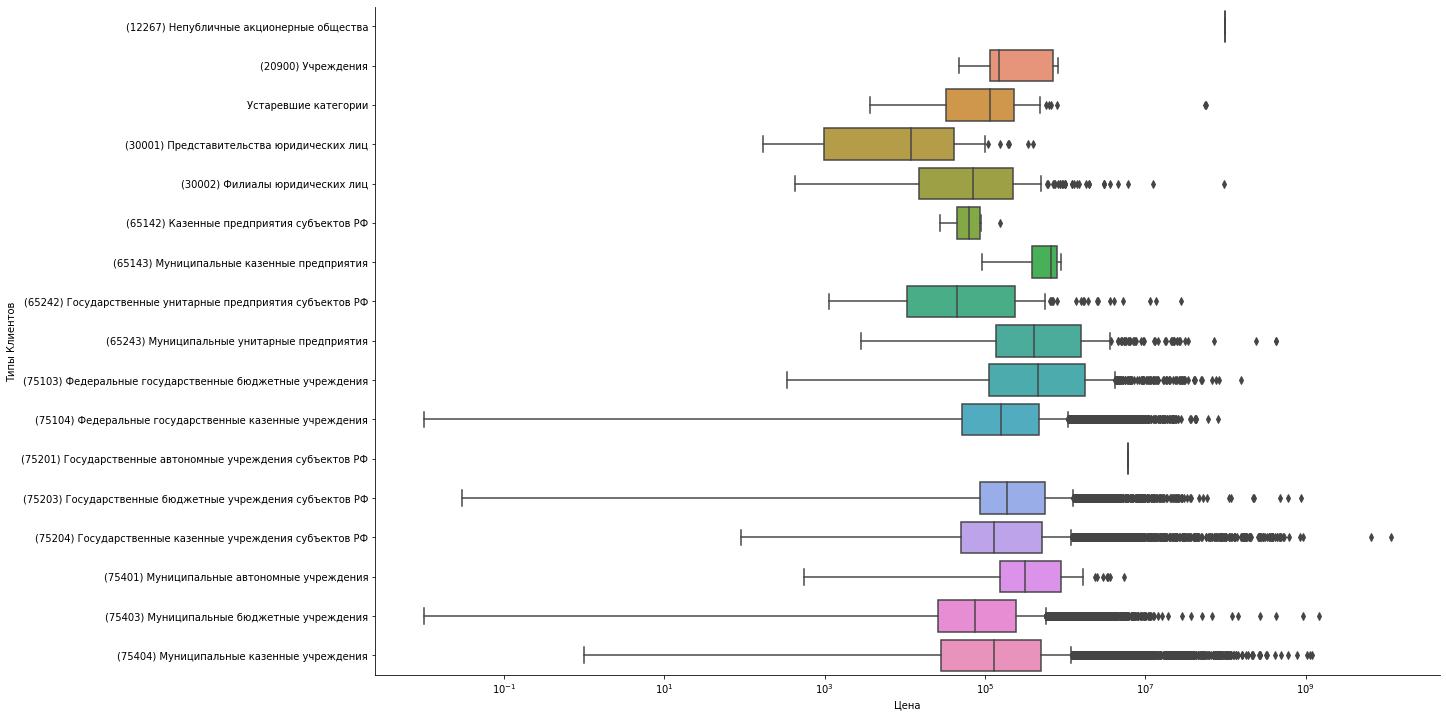

In [36]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'total'], axis=1).sort_values('customer_legal_form')
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  g = sbs.catplot(y = 'customer_legal_form', x = 'total', kind ='box', height = 10, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'Типы Клиентов')
  
del data_to_plot
del g
gc.collect()

Тип клиента и прохождение заявки

15476

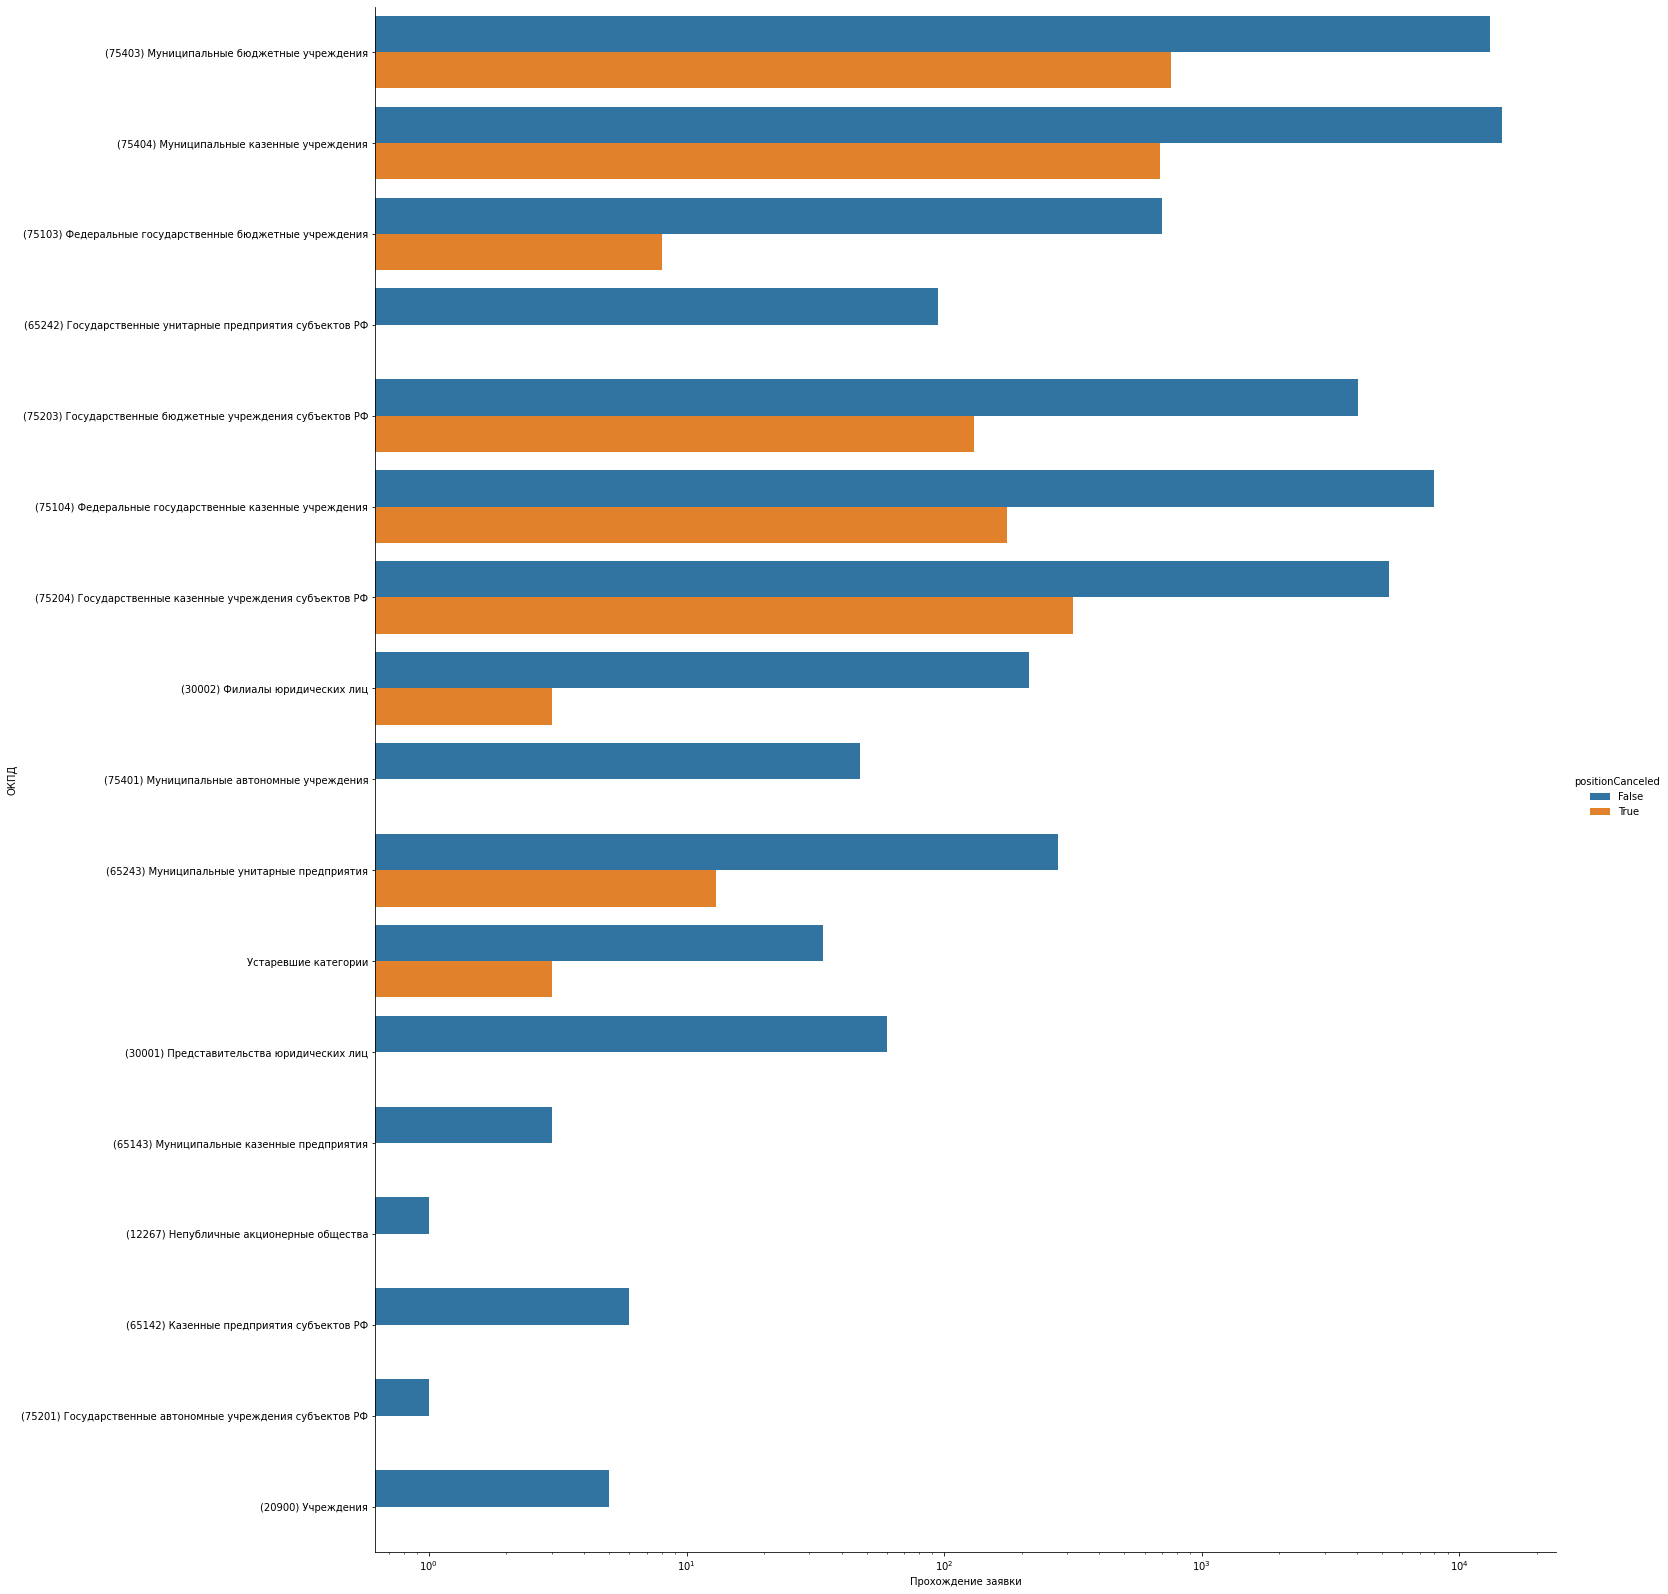

In [37]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'positionCanceled'])
  data_to_plot['customer_legal_form'] = data_to_plot['customer_legal_form'].map(OKOPF_sub)
  g = sbs.catplot(y = 'customer_legal_form', hue="positionCanceled", kind="count", height = 22, aspect = 1, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Прохождение заявки', ylabel = 'ОКПД')

del data_to_plot
del g
gc.collect()

Цена и продолжительность

9889

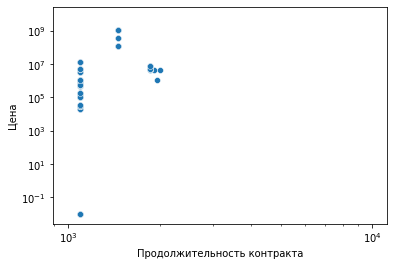

In [ ]:
g = sbs.scatterplot(x = 'time', y = 'total', data = data)
g.set(xscale = 'log', yscale = 'log', xlabel = 'Продолжительность контракта', ylabel = 'Цена')

del g
gc.collect()

1975

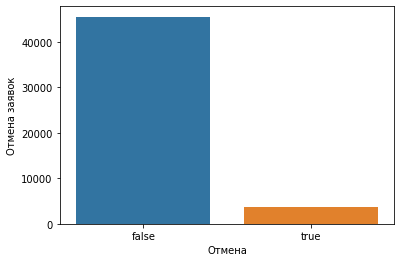

In [ ]:
g = sbs.countplot(x = 'positionCanceled', data = data)
g.set(xlabel = 'Отмена', ylabel = 'Отмена заявок')

del g
gc.collect()

Время и отмена

2058

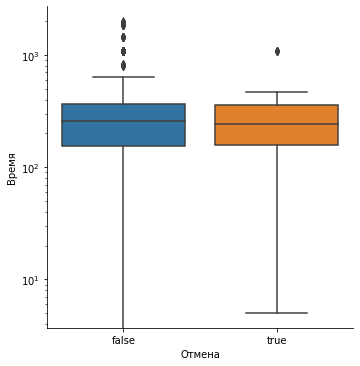

In [ ]:
g = sbs.catplot(x = 'positionCanceled', y = 'time', kind ='box', aspect = 1, data = data)
g.set(yscale = 'log', xlabel = 'Отмена', ylabel = 'Время')

del g
gc.collect()

Цена и отмена

8479

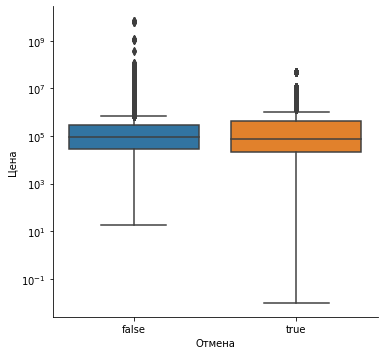

In [ ]:
g = sbs.catplot(x = 'positionCanceled', y = 'total', kind ='box', aspect = 1, data = data)
g.set(yscale = 'log', xlabel = 'Отмена', ylabel = 'Цена')

del g
gc.collect()

#Прогноз отмены

Значимость признаков:
* [70.3223, 'customer_legal_form'],
* [23.3529, 'OKPD'],
* [6.3248, 'KVRInfo'],
* [0.0, 'total'],
* [0.0, 'time'],
* [0.0, 'publicDiscussion'],
* [0.0, 'maxPrice'],
* [0.0, 'OKFS']

In [159]:
cat_var = ['customer_legal_form',
           'OKPD']

In [284]:
data.head()

,customer_legal_form,OKFS,KVRInfo,positionCanceled,publicDiscussion,total,time,OKPD,maxPrice
0,75403,14.0,244.0,False,False,524637.0,731,35,174879.0
1,75404,14.0,244.0,False,False,30000.0,182,35,11700.0
2,75103,12.0,244.0,False,False,7800000.0,1461,35,2600000.0
3,75103,12.0,244.0,False,False,3675000.0,731,35,1225000.0
4,75103,12.0,244.0,False,False,900000.0,731,35,300000.0


In [279]:
x = data.drop(['publicDiscussion',	'total', 'time', 'OKFS', 'maxPrice', 'KVRInfo'], axis=1)
y = data.drop(['customer_legal_form',	'publicDiscussion',	'total', 'time',	'OKPD', 'OKFS', 'KVRInfo', 'maxPrice'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

In [280]:
print("True", len(x_train[x_train['positionCanceled']==True]))
print("False", len(x_train[x_train['positionCanceled']==False]))

True 1851
False 37065


In [281]:
#Балансировка данных
old_indexes = round(len(x_train[x_train['positionCanceled']==False])
 - len(x_train[x_train['positionCanceled']==True]))
x_train.sort_values('positionCanceled', inplace = True)
x_train = x_train.reset_index()
x_train.drop(x_train[((x_train.index < old_indexes) & (x_train['positionCanceled']==False))].index, inplace=True)
x_train = x_train.reset_index(drop=True)

y_train.sort_values('positionCanceled', inplace = True)
y_train = y_train.reset_index()
y_train.drop(y_train[((y_train.index < old_indexes) & (y_train['positionCanceled']==False))].index, inplace=True)
y_train = y_train.reset_index(drop=True)
gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0

In [282]:
print("True", len(x_train[x_train['positionCanceled']==True]))
print("False", len(x_train[x_train['positionCanceled']==False]))

print('True', len(y_train[y_train['positionCanceled'] == True].index))
print('False', len(y_train[y_train['positionCanceled'] == False].index))
print("Разница в трен данных:", 1 - len(y_train[y_train['positionCanceled'] == False].index)/len(y_train[y_train['positionCanceled'] == True].index))

True 1851
False 1851
True 1851
False 1851
Разница в трен данных: 0.0


In [283]:
print("True", len(x_test[x_test['positionCanceled']==True]))
print("False", len(x_test[x_test['positionCanceled']==False]))

True 247
False 9483


In [285]:
x_train_True = x_train[x_train['positionCanceled']==True]
x_train_False = x_train[x_train['positionCanceled']==False]
y_train_True = y_train[y_train['positionCanceled']==True]
y_train_False = y_train[y_train['positionCanceled']==False]

percent = 0.22 #% разницы между тренировочными True и False
droped = round(len(y_train_True)*percent)
x_train_False.drop(x_train_False[x_train_False.index < droped].index, inplace=True)
x_train_False = x_train_False.reset_index(drop=True)
y_train_False.drop(y_train_False[y_train_False.index < droped].index, inplace=True)
y_train_False = y_train_False.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [286]:
x_train = pd.concat([x_train_False, x_train_True])
y_train = pd.concat([y_train_False, y_train_True])

x_train.sort_values('index', inplace = True)
y_train.sort_values('index', inplace = True)

In [287]:
print('True', len(y_train[y_train['positionCanceled'] == True].index))
print('False', len(y_train[y_train['positionCanceled'] == False].index))
print("Разница в трен данных:", 1 - len(y_train[y_train['positionCanceled'] == False].index)/len(y_train[y_train['positionCanceled'] == True].index))

True 1851
False 1444
Разница в трен данных: 0.21988114532685032


In [288]:
print('True', len(y_test[y_test['positionCanceled'] == True].index))
print('False', len(y_test[y_test['positionCanceled'] == False].index))

True 247
False 9483


In [289]:
x_train = x_train.drop(['positionCanceled', 'index'], axis=1)
y_train = y_train.drop(['index'], axis=1)
x_test = x_test.drop(['positionCanceled'], axis=1)

In [290]:
del x_train_True, x_train_False, y_train_True, y_train_False, x, y
gc.collect()

558

In [291]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10}
Mean cross-validated accuracy score of the best_estimator: 0.662
              precision    recall  f1-score   support

       False       1.00      0.28      0.44      9483
        True       0.03      0.96      0.06       247

    accuracy                           0.30      9730
   macro avg       0.51      0.62      0.25      9730
weighted avg       0.97      0.30      0.43      9730



3722

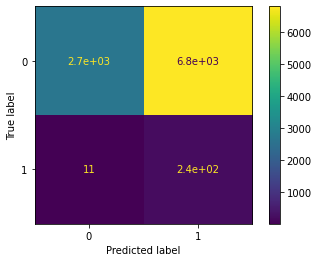

In [296]:
cat_features = cat_var

parameters = {
    "n_estimators": [10],
    "learning_rate": [0.5],
    "max_depth": [5],
}

model_catboost = CatBoostClassifier(
    cat_features = cat_features,
    random_state=42,
    task_type="GPU",
    devices='0:1',
)

model_catboost = GridSearchCV(
    model_catboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_catboost.fit(x_train, y_train, eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)

print(f'Best parameters {model_catboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_catboost.best_score_:.3f}'
)

y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['False', 'True']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

del y_pred
gc.collect()

In [297]:
#значимость признаков для леса
importances = model_catboost.best_estimator_.get_feature_importance()
indices = np.argsort(importances)[::-1]
col = ['customer_legal_form', 'OKPD']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признаков:")
ar_f.sort(reverse=True)
ar_f

Значимость признаков:


[[63.9604, 'customer_legal_form'], [36.0396, 'OKPD']]

In [299]:
model_catboost.best_estimator_.save_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/auction/catboost(isCanseled)")

# Обработка новых данных

In [ ]:
!gdown --id 18LC4oLeERpFgYrpGT-M6TBMqoZwbYsZR

Downloading...
From: https://drive.google.com/uc?id=18LC4oLeERpFgYrpGT-M6TBMqoZwbYsZR
To: /content/purchase_plans.csv
661MB [00:03, 193MB/s]


In [ ]:
!gdown --id 1YTGkut9qlmVSC1o1H6vrzxpR5WsetynX

Downloading...
From: https://drive.google.com/uc?id=1YTGkut9qlmVSC1o1H6vrzxpR5WsetynX
To: /content/tenderplans2017.csv
946MB [00:20, 46.8MB/s]


In [ ]:
!gdown --id 1JiAvvLATEHx7YFfLYyjQp6U3i80iBVqu

Downloading...
From: https://drive.google.com/uc?id=1JiAvvLATEHx7YFfLYyjQp6U3i80iBVqu
To: /content/tenderplans2020.csv
362MB [00:08, 45.1MB/s]


In [ ]:
data

,plan_number,customer_legal_form,positionNumber,positionCanceled,publicDiscussion,total,isEnergyServiceContract,time,OKPD,log_total
0,201801133000253003,75404,201801133000253003000150,False,false,97522.23,false,44,95.12.10.000,11.487836
1,201901133000089001,75404,201901133000089001000001,True,false,195000.00,false,31,35.11.10.000,12.180755
2,201901133000074001,75404,201901133000074001000001,False,false,3117.87,false,365,19.20.21.125,8.044905
3,201901133000089001,75404,201901133000089001000016,False,false,16000.00,false,365,61.10.11.110,9.680344
4,201901133000089001,75404,201901133000089001000001,True,false,195000.00,false,31,35.11.10.000,12.180755
...,...,...,...,...,...,...,...,...,...,...
49199,201903133000056002,75404,201903133000056002000060,False,false,200000.00,false,122,62.01.29.000,12.206073
49200,201903133000056002,75404,201903133000056002000060,False,false,200000.00,false,122,62.01.29.000,12.206073
49201,201903133000056002,75404,201903133000056002000060,False,false,200000.00,false,122,62.01.29.000,12.206073
49202,201903133000056002,75404,201903133000056002000060,False,false,200000.00,false,122,62.01.29.000,12.206073


In [ ]:
contract_path1 = 'purchase_plans.csv'
data = pd.read_csv(contract_path1)
data = data.drop(['id', 'periodicity', 'publish_date', 'isEnergyServiceContract', 'currentYear','firstYear', 'secondYear', 'subsecYears'], axis=1)
data['execution_period_start'] = pd.to_datetime(data['execution_period_start'], format = "%Y-%m-%d", errors = 'coerce')
data['execution_period_end'] = pd.to_datetime(data['execution_period_end'], format = "%Y-%m-%d", errors = 'coerce')
data.sort_values('execution_period_start', inplace = True)
data.dropna(inplace = True)
data = data.reset_index(drop=True)
gc.collect()
data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,plan_number,customer_legal_form,OKFS,positionNumber,product_info,KVRInfo,execution_period_start,execution_period_end,positionCanceled,publicDiscussion,total
0,201703133000188001,75403,14.0,201703133000188001000001,35.14.10.000,244.0,2016-01-01,2017-12-31,False,False,524637.0
1,201703133000164001,75404,14.0,201703133000164001000002,35.11.10.110,244.0,2016-01-01,2016-06-30,False,False,30000.0
2,201703133000499001,75403,14.0,201703133000499001000001,35.30.11.120,244.0,2016-01-01,2016-06-30,False,False,188000.0
3,201703131000014001,75103,12.0,201703131000014001000001,35.30.11.120,244.0,2016-01-01,2019-12-31,False,False,7800000.0
4,201703131000014001,75103,12.0,201703131000014001000003,35.11.10.110,244.0,2016-01-01,2017-12-31,False,False,3675000.0
...,...,...,...,...,...,...,...,...,...,...,...
1832310,201701131000051001,75104,12.0,201701131000051001000041,35.30.11.111,244.0,2108-01-01,2018-12-01,False,False,1909080.0
1832311,201701131000051001,75104,12.0,201701131000051001000041,35.30.11.111,244.0,2108-01-01,2018-12-01,False,False,1909080.0
1832312,201701131000051001,75104,12.0,201701131000051001000041,35.30.11.111,244.0,2108-01-01,2018-12-01,False,False,1909080.0
1832313,201701131000051001,75104,12.0,201701131000051001000041,35.30.11.111,244.0,2108-01-01,2018-12-01,False,False,1909080.0


In [ ]:
data = data[(data['execution_period_start'] < pd.to_datetime('2100-01-01', format="%Y-%m-%d")) & (data['execution_period_start'] > pd.to_datetime('1991-01-01', format="%Y-%m-%d"))]
data = data[(data['execution_period_end'] < pd.to_datetime('2100-01-01', format="%Y-%m-%d")) & (data['execution_period_end'] > pd.to_datetime('1991-01-01', format="%Y-%m-%d"))]

In [ ]:
def calculate_time_period(row):
  return ((row['execution_period_end'] - row['execution_period_start']).days + 1)

data['time'] = data[['execution_period_end', 'execution_period_start']].apply(calculate_time_period, axis=1)
gc.collect()

0

In [ ]:
data = data[(data['total'] > 0)]

In [ ]:
checkpoint = data.copy()

In [ ]:
data = data.drop(['execution_period_start', 'execution_period_end'], axis=1)

In [ ]:
len(data['product_info'].unique())

3381

In [ ]:
def new_column(row):
  return (row['product_info'].rsplit("-")[0])

data['OKPD'] = data[['product_info']].apply(new_column, axis=1)

In [ ]:
len(data['OKPD'].unique())

3171

In [ ]:
data = data.drop(['product_info'], axis=1)

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data['log_total'] = np.log(data['total'])

In [ ]:
data

,plan_number,customer_legal_form,OKFS,positionNumber,KVRInfo,positionCanceled,publicDiscussion,total,time,OKPD,log_total
0,201703133000188001,75403,14.0,201703133000188001000001,244.0,False,False,524637.0,731,35.14.10.000,13.170462
1,201703133000164001,75404,14.0,201703133000164001000002,244.0,False,False,30000.0,182,35.11.10.110,10.308953
2,201703133000499001,75403,14.0,201703133000499001000001,244.0,False,False,188000.0,182,35.30.11.120,12.144197
3,201703131000014001,75103,12.0,201703131000014001000001,244.0,False,False,7800000.0,1461,35.30.11.120,15.869634
4,201703131000014001,75103,12.0,201703131000014001000003,244.0,False,False,3675000.0,731,35.11.10.110,15.117064
...,...,...,...,...,...,...,...,...,...,...,...
1709775,201903133000056002,75404,14.0,201903133000056002000061,244.0,False,False,40000.0,92,62.09.20.190,10.596635
1709776,201903133000056002,75404,14.0,201903133000056002000061,244.0,False,False,40000.0,92,62.09.20.190,10.596635
1709777,201903133000056002,75404,14.0,201903133000056002000061,244.0,False,False,40000.0,92,62.09.20.190,10.596635
1709778,201903133000056002,75404,14.0,201903133000056002000061,244.0,False,False,40000.0,92,62.09.20.190,10.596635


In [ ]:
contract_path2 = 'tenderplans2017.csv'
dtypes = {'positionNumber' : 'category'}
data = pd.read_csv(contract_path2, dtype = dtypes)
data2 = pd.read_csv(contract_path2)
data2 = data2.drop(['plan_number', 'publish_date', 'publish_date', 'customer_legal_form', 'OKFS','id', 'purchasePlanPositionNumber', 'placingWayInfo'], axis=1)
data2 = data2.reset_index(drop=True)
data2.dropna(inplace = True)
gc.collect()
data2

,positionNumber,maxPrice
2100,201701133000009002000003,182000.00
2149,201701133000022002000001,104531.29
2150,201701133000022002000002,944987.46
2151,201701133000022002000003,1490403.76
2152,201701133000022002000004,22345.62
...,...,...
5738047,201908136000032001000008,1500000.00
5738048,201908136000032001000010,279929.40
5738049,201908136000032001000013,1500000.00
5738050,201908136000032001000014,1500000.00


In [ ]:
contract_path3 = 'tenderplans2020.csv'
dtypes = {'positionNumber' : 'category'}
data = pd.read_csv(contract_path3, dtype = dtypes)
data3 = pd.read_csv(contract_path3)
data3 = data3.drop(['plan_number', 'publish_date', 'publish_date', 'customer_legal_form', 'OKFS','id', 'purchasePlanPositionNumber', 'placingWayInfo'], axis=1)
data3 = data3.reset_index(drop=True)
data3.dropna(inplace = True)
gc.collect()
data3

,positionNumber,maxPrice
0,202003133000034001000001,1182667.50
1,202001131000070001000071,2455872.74
2,202001131000070001000075,3479931.94
3,202001131000070001000009,203000.00
4,202001131000070001000010,1190400.00
...,...,...
2273920,202110133000036002000013,183386.09
2273921,202110133000041004000011,187600.00
2273922,202110133000041004000011,187600.00
2273923,202110133000041004000012,18265.60


In [ ]:
new_data = pd.concat([data2, data3])
new_data = new_data.reset_index(drop=True)
new_data

,positionNumber,maxPrice
0,201701133000009002000003,182000.00
1,201701133000022002000001,104531.29
2,201701133000022002000002,944987.46
3,201701133000022002000003,1490403.76
4,201701133000022002000004,22345.62
...,...,...
8006675,202110133000036002000013,183386.09
8006676,202110133000041004000011,187600.00
8006677,202110133000041004000011,187600.00
8006678,202110133000041004000012,18265.60


In [ ]:
new_data.drop_duplicates(['positionNumber'], inplace = True)
data.drop_duplicates(['positionNumber'], inplace = True)

In [ ]:
new_data = new_data.reset_index(drop=True)
new_data['log_maxPrice'] = np.log(new_data['maxPrice'])
new_data

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,positionNumber,maxPrice,log_maxPrice
0,201701133000009002000003,182000.00,12.111762
1,201701133000022002000001,104531.29,11.557242
2,201701133000022002000002,944987.46,13.758927
3,201701133000022002000003,1490403.76,14.214558
4,201701133000022002000004,22345.62,10.014386
...,...,...,...
190202,202110133000034001000009,153354.83,11.940510
190203,202110133000036002000013,183386.09,12.119349
190204,202110133000041004000011,187600.00,12.142067
190205,202110133000041004000012,18265.60,9.812775


In [ ]:
data = data.reset_index(drop=True)
data

,plan_number,customer_legal_form,OKFS,positionNumber,KVRInfo,positionCanceled,publicDiscussion,total,time,OKPD,log_total
0,201703133000188001,75403,14.0,201703133000188001000001,244.0,False,False,524637.0,731,35.14.10.000,13.170462
1,201703133000164001,75404,14.0,201703133000164001000002,244.0,False,False,30000.0,182,35.11.10.110,10.308953
2,201703133000499001,75403,14.0,201703133000499001000001,244.0,False,False,188000.0,182,35.30.11.120,12.144197
3,201703131000014001,75103,12.0,201703131000014001000001,244.0,False,False,7800000.0,1461,35.30.11.120,15.869634
4,201703131000014001,75103,12.0,201703131000014001000003,244.0,False,False,3675000.0,731,35.11.10.110,15.117064
...,...,...,...,...,...,...,...,...,...,...,...
71954,201903131000005001,75104,12.0,201903131000005001000007,244.0,False,False,110000.0,149,53.20.11.110,11.608236
71955,201901131000007001,75104,12.0,201901131000007001000031,244.0,False,False,120000.0,46,17.23.12.110,11.695247
71956,201903133000472003,75404,14.0,201903133000472003000164,242.0,False,False,701000.0,114,62.01,13.460263
71957,201903133000472003,75404,14.0,201903133000472003000165,242.0,False,False,600000.0,113,62.02,13.304685


In [ ]:
data = data.join(new_data.set_index('positionNumber'), on = 'positionNumber')

In [ ]:
data.dropna(inplace = True)
data = data.reset_index(drop=True)
data

,plan_number,customer_legal_form,OKFS,positionNumber,KVRInfo,positionCanceled,publicDiscussion,total,time,OKPD,log_total,maxPrice,log_maxPrice
0,201703133000188001,75403,14.0,201703133000188001000001,244.0,False,False,524637.00,731,35.14.10.000,13.170462,174879.00,12.071850
1,201703133000164001,75404,14.0,201703133000164001000002,244.0,False,False,30000.00,182,35.11.10.110,10.308953,11700.00,9.367344
2,201703131000014001,75103,12.0,201703131000014001000001,244.0,False,False,7800000.00,1461,35.30.11.120,15.869634,2600000.00,14.771022
3,201703131000014001,75103,12.0,201703131000014001000003,244.0,False,False,3675000.00,731,35.11.10.110,15.117064,1225000.00,14.018451
4,201703131000014001,75103,12.0,201703131000014001000002,244.0,False,False,900000.00,731,35.30.12.120,13.710150,300000.00,12.611538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48641,201903131000048001,75104,12.0,201903131000048001000059,244.0,False,False,572198.52,365,81.21,13.257241,572198.52,13.257241
48642,201903131000048001,75104,12.0,201903131000048001000063,244.0,False,False,50000.00,365,36.00.11.000,10.819778,50000.00,10.819778
48643,201903131000048001,75104,12.0,201903131000048001000062,244.0,False,False,280000.00,365,53.10,12.542545,280000.00,12.542545
48644,201903131000048001,75104,12.0,201903131000048001000054,244.0,False,False,300000.00,365,43.39.1,12.611538,300000.00,12.611538


In [ ]:
data = data.drop(['positionNumber'], axis=1)

In [ ]:
data.to_csv('/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/purchase_plans.csv', index = False)